In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

orders_cleaned = pd.read_pickle("orders_cleaned.pkl")

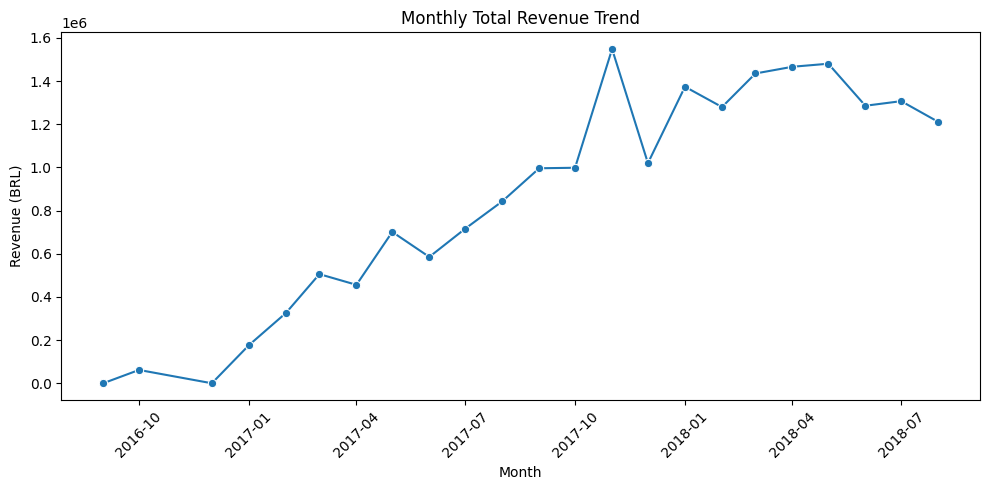

,order_month,total_revenue
0,2016-09-01,0.00
1,2016-10-01,61746.94
2,2016-12-01,19.62
3,2017-01-01,176491.49
4,2017-02-01,325782.66


In [2]:
#Monthly revenue time series
orders_cleaned["order_month"] = orders_cleaned["order_purchase_timestamp"].dt.to_period("M")
monthly_revenue = (
    orders_cleaned.groupby("order_month")
    .agg(total_revenue=("payment_value", "sum"))
    .reset_index()
)
monthly_revenue["order_month"] = monthly_revenue["order_month"].dt.to_timestamp()

#Plot trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_revenue, x="order_month", y="total_revenue", marker="o")
plt.title("Monthly Total Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_revenue.head()

In [4]:
!pip install statsmodels

                                              0.0/9.8 MB ? eta -:--:--
                                              0.0/9.8 MB ? eta -:--:--
                                              0.0/9.8 MB ? eta -:--:--
                                              0.0/9.8 MB ? eta -:--:--
                                              0.0/9.8 MB ? eta -:--:--
                                              0.1/9.8 MB 5.1 MB/s eta 0:00:02
     -                                        0.3/9.8 MB 4.5 MB/s eta 0:00:03
     -                                        0.5/9.8 MB 4.7 MB/s eta 0:00:03
     -                                        0.5/9.8 MB 4.7 MB/s eta 0:00:03
     --                                       0.5/9.8 MB 2.4 MB/s eta 0:00:04
     --                                       0.7/9.8 MB 2.5 MB/s eta 0:00:04
     ---                                      0.8/9.8 MB 2.8 MB/s eta 0:00:04
     ----                                     1.1/9.8 MB 3.2 MB/s eta 0:00:03
     -----           


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Forecasting : ES

C:\Users\Vaishnavi J\anaconda3\envs\supplyenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


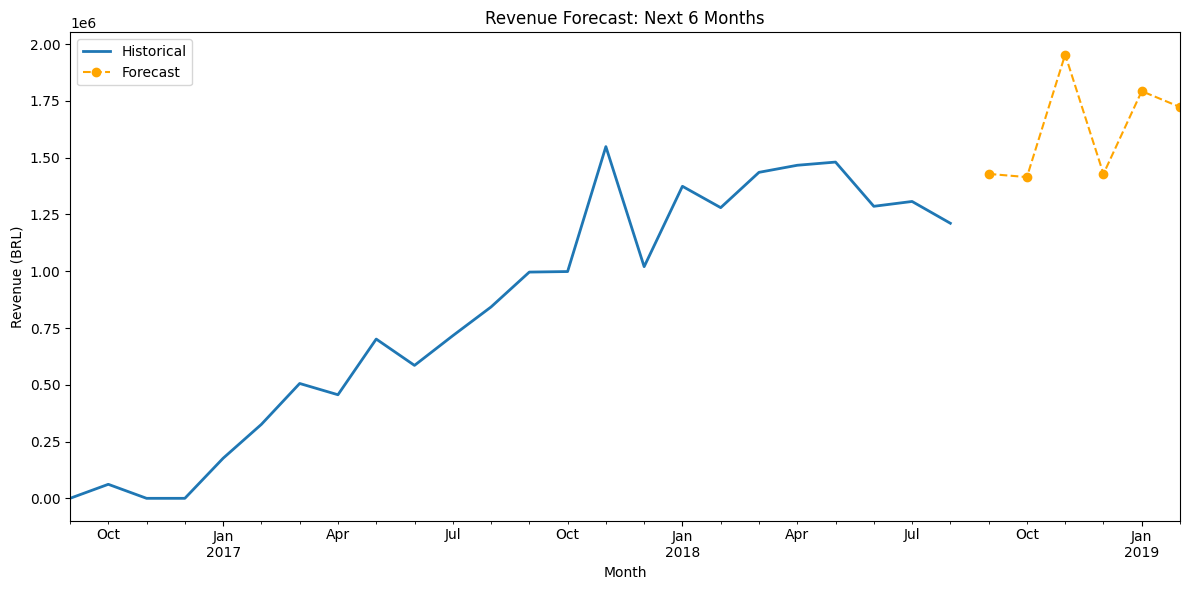

2018-09-01    1428661.31
2018-10-01    1414500.38
2018-11-01    1954256.15
2018-12-01    1428390.30
2019-01-01    1792841.54
2019-02-01    1723102.92
Freq: MS, dtype: float64

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Build and fit an Exponential Smoothing model
monthly_revenue.set_index("order_month", inplace=True)
monthly_revenue = monthly_revenue.asfreq("MS")  # ensure proper monthly frequency

#Fill any missing months with 0 revenue (if any)
monthly_revenue["total_revenue"] = monthly_revenue["total_revenue"].fillna(0)

#Fit model
model = ExponentialSmoothing(
    monthly_revenue["total_revenue"],
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit()

#Forecast next 6 months
forecast = model.forecast(6)

#Plot historical + forecast
plt.figure(figsize=(12, 6))
monthly_revenue["total_revenue"].plot(label="Historical", linewidth=2)
forecast.plot(label="Forecast", linestyle="--", marker="o", color="orange")
plt.title("Revenue Forecast: Next 6 Months")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.legend()
plt.tight_layout()
plt.show()

forecast.round(2)

Forecasting : SARIMA

C:\Users\Vaishnavi J\anaconda3\envs\supplyenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


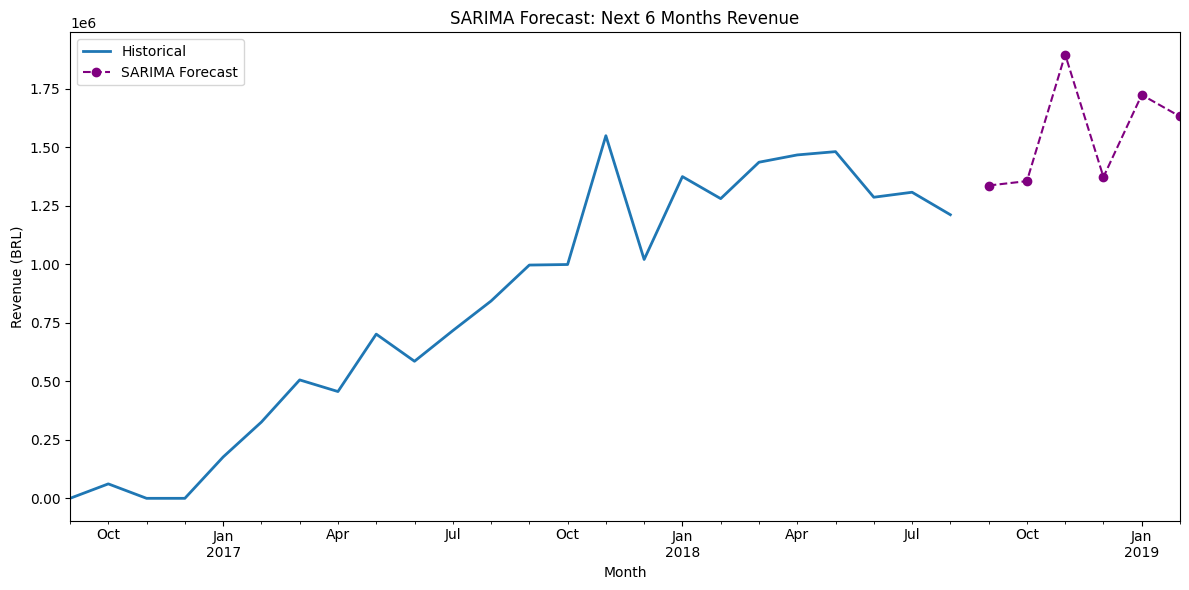

2018-09-01    1335945.63
2018-10-01    1354771.62
2018-11-01    1895423.71
2018-12-01    1372188.68
2019-01-01    1723112.65
2019-02-01    1630773.97
Freq: MS, Name: predicted_mean, dtype: float64

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Fit SARIMA model (1,1,1)x(1,1,1,12) for seasonality
sarima_model = SARIMAX(
    monthly_revenue["total_revenue"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#Forecast next 6 months
sarima_forecast = sarima_model.forecast(steps=6)
sarima_forecast.index = pd.date_range(start=monthly_revenue.index.max() + pd.offsets.MonthBegin(1), periods=6, freq="MS")

#Plot SARIMA forecast alongside historical data
plt.figure(figsize=(12, 6))
monthly_revenue["total_revenue"].plot(label="Historical", linewidth=2)
sarima_forecast.plot(label="SARIMA Forecast", linestyle="--", marker="o", color="purple")
plt.title("SARIMA Forecast: Next 6 Months Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.legend()
plt.tight_layout()
plt.show()

sarima_forecast.round(2)

Should-cost analysis (Price + Freight)

C:\Users\Vaishnavi J\AppData\Local\Temp\ipykernel_3748\3565634419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_costs, x="should_cost", y="product_category_name_english", palette="Reds_r")


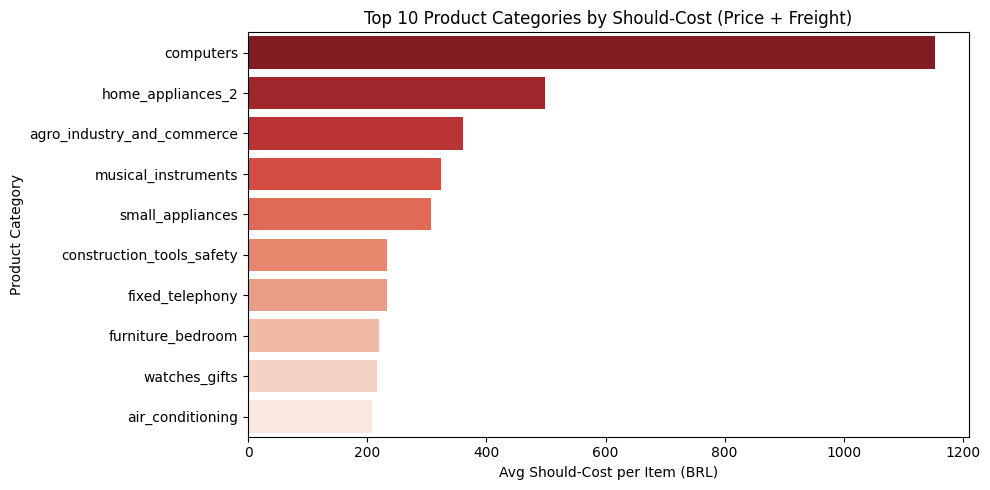

,avg_price,avg_freight,total_orders,should_cost
product_category_name_english,,,,
computers,1104.32,48.11,216,1152.43
home_appliances_2,451.73,46.10,261,497.83
agro_industry_and_commerce,332.84,27.48,246,360.32
musical_instruments,296.11,27.38,688,323.49
small_appliances,283.86,23.64,680,307.50
construction_tools_safety,213.19,20.27,187,233.46
fixed_telephony,214.69,17.64,261,232.33
furniture_bedroom,176.04,43.69,119,219.73
watches_gifts,200.07,16.80,6065,216.87


In [7]:
#Group by product category and compute average price + freight (cost proxy)
category_costs = (
    orders_cleaned.groupby("product_category_name_english")
    .agg(
        avg_price=("price", "mean"),
        avg_freight=("freight_value", "mean"),
        total_orders=("order_id", "count")
    )
    .dropna()
)

#compute "should-cost" = avg_price + avg_freight
category_costs["should_cost"] = category_costs["avg_price"] + category_costs["avg_freight"]

#sort by should-cost and filter out categories with low volume
category_costs_filtered = category_costs[category_costs["total_orders"] > 100].sort_values(by="should_cost", ascending=False)

#Plot top 10 highest-cost categories
top_costs = category_costs_filtered.head(10).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_costs, x="should_cost", y="product_category_name_english", palette="Reds_r")
plt.title("Top 10 Product Categories by Should-Cost (Price + Freight)")
plt.xlabel("Avg Should-Cost per Item (BRL)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

#show full table of cost estimates
category_costs_filtered.round(2)

In [8]:
category_costs_filtered.to_pickle("category_costs_filtered.pkl")